In [3]:
## Manipulación de datos
import pandas as pd
import numpy as np

## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os
import sys

## Modelos
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [5]:
X = df.drop(columns=['Order_Date','Buyer_Gender'])
y = df['Buyer_Gender']

In [6]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y, random_state=42)
print(mi_scores)


[0.         0.00399719 0.00140226 0.         0.00933511 0.
 0.00067422 0.         0.00479589 0.00474398 0.         0.
 0.00263262]


In [7]:
df['Price_Per_Unit'] = df['Sales_Price'] / df['Quantity']
df['Price_Category'] = pd.cut(df['Sales_Price'], bins=[0, 50, 200, 1000], labels=[1,2,3])


In [8]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Order_Weekday'] = df['Order_Date'].dt.dayofweek.astype(int)
df['Order_Month'] = df['Order_Date'].dt.month.astype(int)

In [9]:
df['Price_Category'] = df['Price_Category'].astype(int)

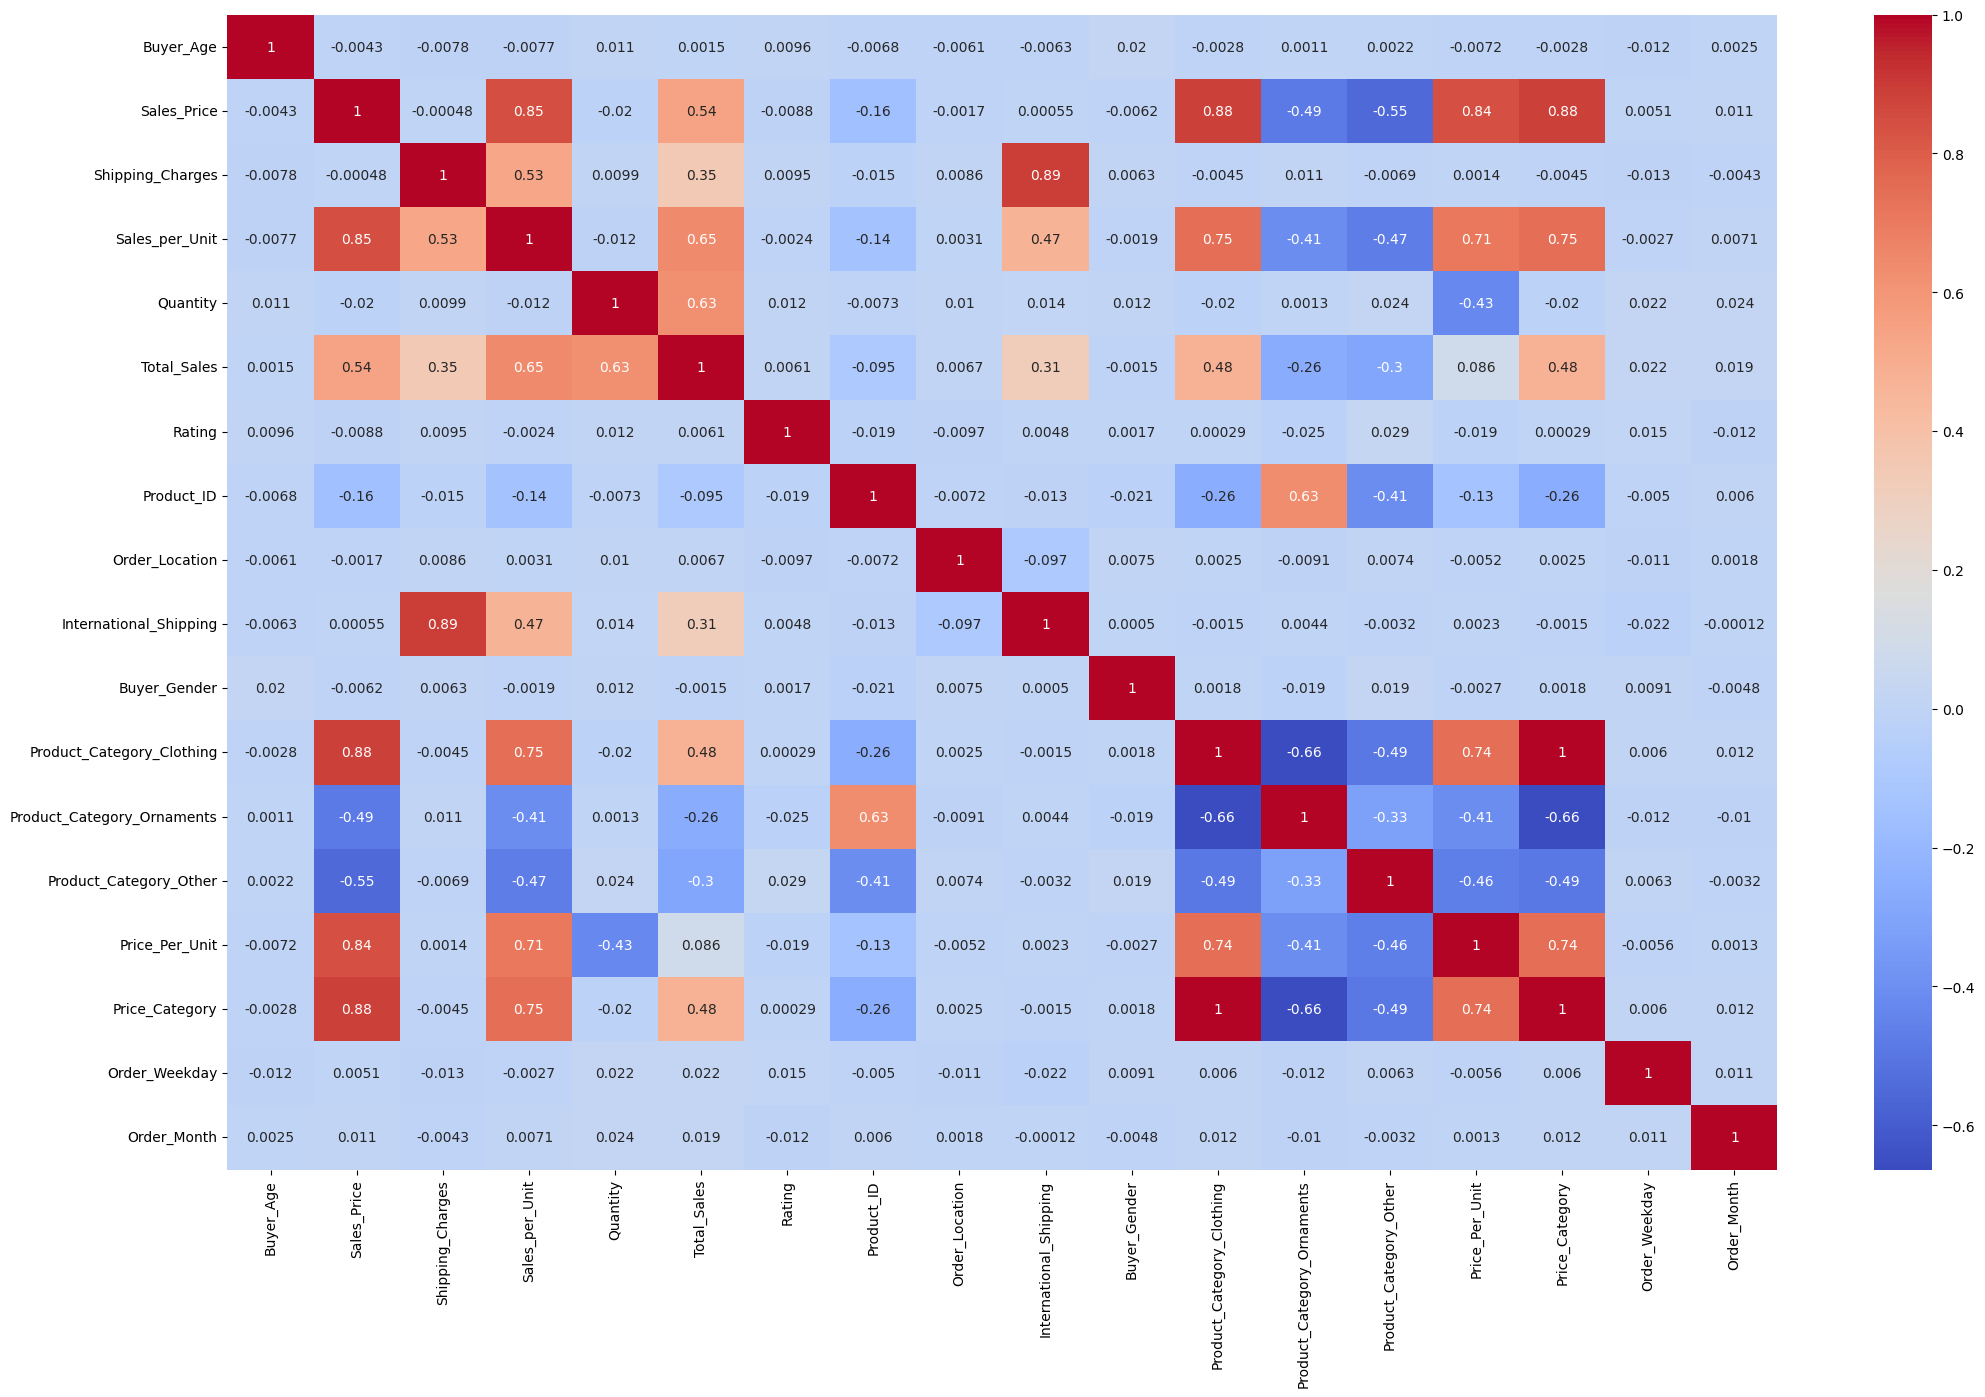

In [10]:
plt.figure(figsize=(25,15))

df_future = df.drop(columns='Order_Date')
corr = df_future.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm");

Tratando de hacer un poco de future engineer para ver si logramos encontrar variables con algo de relacion al genero del comprador. No ha sifo posible por el momento.

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

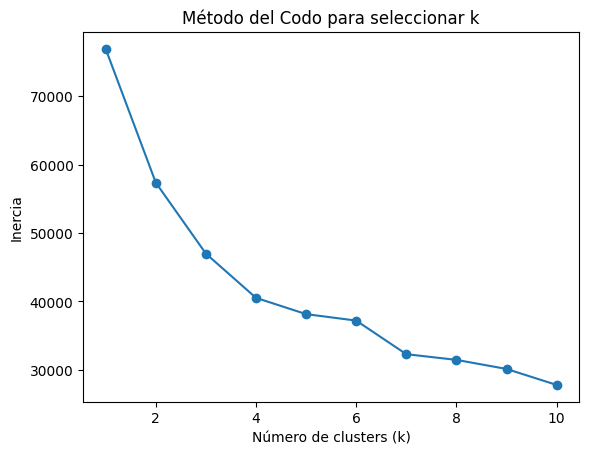

In [13]:
inertia = []
K_range = range(1, 11)  # Probar entre 1 y 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)  # Inercia = suma de distancias dentro del cluster

# 🔹 Graficar el método del codo
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para seleccionar k')
plt.show()


In [14]:
kmeans = KMeans(n_clusters=5,random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train_scaled)
X_test['cluster'] = kmeans.predict(X_test_scaled)  # Se puede aplicar en test


In [15]:
X_train['cluster'].value_counts()

cluster
0    2245
3    1247
2    1130
4     712
1     581
Name: count, dtype: int64

In [16]:
# 🔹 Filtrar por cluster
X_train_0, y_train_0 = X_train[X_train['cluster'] == 0].drop(columns=['cluster']), y_train[X_train['cluster'] == 0]
X_train_1, y_train_1 = X_train[X_train['cluster'] == 1].drop(columns=['cluster']), y_train[X_train['cluster'] == 1]
X_train_2, y_train_2 = X_train[X_train['cluster'] == 2].drop(columns=['cluster']), y_train[X_train['cluster'] == 2]
X_train_3, y_train_3 = X_train[X_train['cluster'] == 3].drop(columns=['cluster']), y_train[X_train['cluster'] == 3]
X_train_4, y_train_4 = X_train[X_train['cluster'] == 4].drop(columns=['cluster']), y_train[X_train['cluster'] == 4]

X_test_0, y_test_0 = X_test[X_test['cluster'] == 0].drop(columns=['cluster']), y_test[X_test['cluster'] == 0]
X_test_1, y_test_1 = X_test[X_test['cluster'] == 1].drop(columns=['cluster']), y_test[X_test['cluster'] == 1]
X_test_2, y_test_2 = X_test[X_test['cluster'] == 2].drop(columns=['cluster']), y_test[X_test['cluster'] == 2]
X_test_3, y_test_3 = X_test[X_test['cluster'] == 3].drop(columns=['cluster']), y_test[X_test['cluster'] == 3]
X_test_4, y_test_4 = X_test[X_test['cluster'] == 4].drop(columns=['cluster']), y_test[X_test['cluster'] == 4]


In [17]:
rf_0 = RandomForestClassifier(class_weight="balanced", random_state=42).fit(X_train_0, y_train_0)
rf_1 = RandomForestClassifier(class_weight="balanced", random_state=42).fit(X_train_1, y_train_1)
rf_2 = RandomForestClassifier(class_weight="balanced", random_state=42).fit(X_train_2, y_train_2)
rf_3 = RandomForestClassifier(class_weight="balanced", random_state=42).fit(X_train_3, y_train_3)
rf_4 = RandomForestClassifier(class_weight="balanced", random_state=42).fit(X_train_4, y_train_4)


In [18]:
pred_0 = rf_0.predict(X_test_0)
pred_1 = rf_1.predict(X_test_1)
pred_2 = rf_2.predict(X_test_2)
pred_3 = rf_3.predict(X_test_3)
pred_4 = rf_4.predict(X_test_4)

# 🔹 Evaluar cada modelo
print("🔹 Cluster 0:")
print(classification_report(y_test_0, pred_0))

print("🔹 Cluster 1:")
print(classification_report(y_test_1, pred_1))

print("🔹 Cluster 2:")
print(classification_report(y_test_2, pred_2))

print("🔹 Cluster 3:")
print(classification_report(y_test_3, pred_3))

print("🔹 Cluster 4:")
print(classification_report(y_test_4, pred_4))


🔹 Cluster 0:
              precision    recall  f1-score   support

           0       0.30      0.21      0.25       177
           1       0.68      0.77      0.72       380

    accuracy                           0.59       557
   macro avg       0.49      0.49      0.49       557
weighted avg       0.56      0.59      0.57       557

🔹 Cluster 1:
              precision    recall  f1-score   support

           0       0.36      0.16      0.22        50
           1       0.65      0.85      0.74        92

    accuracy                           0.61       142
   macro avg       0.51      0.50      0.48       142
weighted avg       0.55      0.61      0.55       142

🔹 Cluster 2:
              precision    recall  f1-score   support

           0       0.22      0.12      0.16        80
           1       0.68      0.81      0.74       183

    accuracy                           0.60       263
   macro avg       0.45      0.47      0.45       263
weighted avg       0.54      0.60  

In [19]:
pca = PCA(n_components=0.95)  # Mantiene el 95% de la varianza
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [31]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))


[[ 83 384]
 [191 821]]
              precision    recall  f1-score   support

           0       0.30      0.18      0.22       467
           1       0.68      0.81      0.74      1012

    accuracy                           0.61      1479
   macro avg       0.49      0.49      0.48      1479
weighted avg       0.56      0.61      0.58      1479



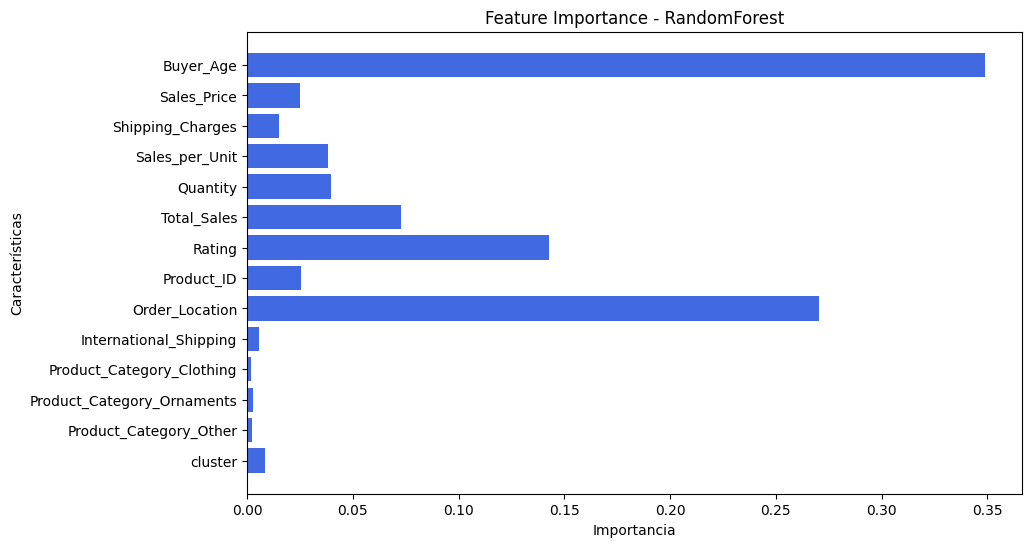

In [32]:
feature_importances = rf.feature_importances_

# Crear un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,  # Usar los nombres reales de las columnas seleccionadas
    "Importance": feature_importances
})


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Feature Importance - RandomForest")
plt.gca().invert_yaxis()
plt.show()

In [49]:
log_model = LogisticRegression(C=1.0, random_state=1, class_weight="balanced")  # Balanceo de clases
log_model.fit(X_train_pca, y_train)

pred_log = log_model.predict(X_test_pca)
print(confusion_matrix(y_test,pred_log))
print(classification_report(y_test, pred_log))

[[338 129]
 [741 271]]
              precision    recall  f1-score   support

           0       0.31      0.72      0.44       467
           1       0.68      0.27      0.38      1012

    accuracy                           0.41      1479
   macro avg       0.50      0.50      0.41      1479
weighted avg       0.56      0.41      0.40      1479



In [50]:
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=1,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42)

xgb.fit(X_train_pca, y_train)

pred_xgb = rf.predict(X_test_pca)
print(confusion_matrix(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))

[[ 95 372]
 [226 786]]
              precision    recall  f1-score   support

           0       0.30      0.20      0.24       467
           1       0.68      0.78      0.72      1012

    accuracy                           0.60      1479
   macro avg       0.49      0.49      0.48      1479
weighted avg       0.56      0.60      0.57      1479



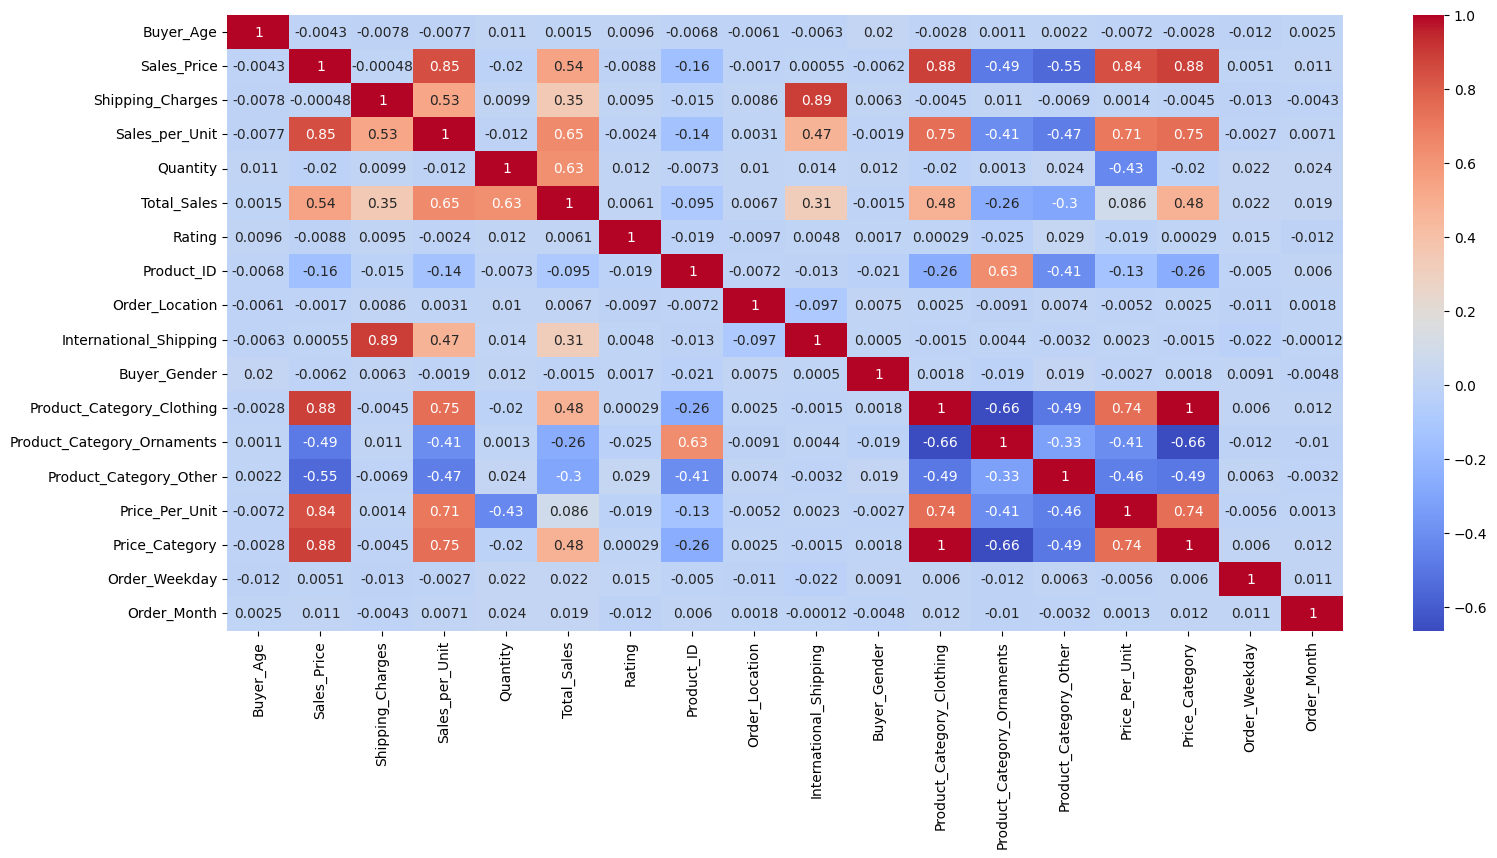

In [51]:
plt.figure(figsize=(18,8))

df_num = df.drop(columns='Order_Date')
corr = df_num.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm");

Observamos que no hay ninguna correlacion entre la target y las demas variables, por lo que dificulta enormemente realizar cualquier prediccion.

In [52]:
from tensorflow import keras
from keras import layers

In [53]:
model = keras.Sequential([

    layers.Dense(128, activation='relu',input_shape=(X_train_0.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(32,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.20),
    layers.Dense(1,activation='sigmoid')
    ])


model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


In [54]:
model.summary();

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,633 (53.25 KB)

 Trainable params: 13,153 (51.38 KB)

 Non-trainable params: 480 (1.88 KB)

In [55]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30,
                                               min_delta=0.01,
                                               restore_best_weights=True,
                                               )

reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                              patience=10,
                                              min_lr=0.00001,
                                              monitor='val_loss')

In [56]:
class_weights = {0: (len(y_train_0) / (2 * np.bincount(y_train_0)[0])), 
                 1: (len(y_train_0) / (2 * np.bincount(y_train_0)[1]))}


In [57]:
history = model.fit(X_train_0,
                    y_train_0,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weights
                    )

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5212 - loss: 0.8343 - val_accuracy: 0.3630 - val_loss: 0.7550
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5153 - loss: 0.8036 - val_accuracy: 0.4053 - val_loss: 0.7774
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5308 - loss: 0.7563 - val_accuracy: 0.5434 - val_loss: 0.7215
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5170 - loss: 0.7540 - val_accuracy: 0.5390 - val_loss: 0.6871
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5386 - loss: 0.7369 - val_accuracy: 0.6169 - val_loss: 0.6671
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5069 - loss: 0.7467 - val_accuracy: 0.5880 - val_loss: 0.6770
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5213 - loss: 0.7464 - val_accuracy: 0.6370 - val_loss: 0.6677
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5272 - loss: 0.7354 - val_accuracy: 0.5657 - v

In [59]:
keras_pred = model.predict(X_test_0)

# Convertir probabilidades a 0 o 1 con umbral de 0.5
keras_pred_bin = (keras_pred > 0.5).astype(int)

# Evaluar con sklearn
print(confusion_matrix(y_test_0, keras_pred_bin))
print(classification_report(y_test_0, keras_pred_bin))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 58 119]
 [120 260]]
              precision    recall  f1-score   support

           0       0.33      0.33      0.33       177
           1       0.69      0.68      0.69       380

    accuracy                           0.57       557
   macro avg       0.51      0.51      0.51       557
weighted avg       0.57      0.57      0.57       557

